# $E_\text{peak} - E_\gamma$ correlation
In this notebook we are trying to do a similar thing as in [Epeak_Eiso_correlation.ipynb](https://github.com/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_correlation.ipynb), where we computed the relation between $E_{\text{peak}}$ and $E_\text{iso}$. However, we know from the jet break, i.e. the jet break time ($t_\text{break}$, when $\theta_\text{jet} \sim \theta_\Gamma \sim 1/\Gamma$) that GRBs haven't spherical outflows but rather a jet (i.e. collimated ejection). Therefore, we want to correct the isotropic equivalent energy $E_\text{iso}$ used in the previous notebook and use the collimation-corrected energy $E_\gamma$. The collimation factor $f$ is defined by
$$f = 1 - \cos\theta_\text{jet}$$

This equation derives from the definition of the solid angle (see notes), with which actually we can derive a collimation factor begin
$$f = \Omega_\text{jet}/\Omega_\text{sphere} = \frac{1-\cos\theta_\text{jet}}{2}$$
, where $\Omega$ is the solid angle. However, since the half-opening angle of the jet is very small ($\theta_\text{jet} < 5\ \text{deg}$) one can approximate as $1 - \cos\theta \sim \theta^2/2$.

I don't have measurements for the $\theta_\text{jet}$ angle yet, since the table I got from $\textit{Ghirlanda et al. 2008}$ does not contain that column. However, we can begin drafting the code using synthetic data. With that aim we're going to define a list of jet half-opening angles as using `np.random.unifrom()` for the interval $\theta_\text{jet} \in \left[0, 0.08 \right]$ ($3\ \text{deg} \sim 0.05\ \text{rad}$)

_**from older notebook**_: The correlation can also be done between $E_{peak}$ and $E_\gamma$, which is the collimation-corrected energy, where $E_\gamma = E_{iso} \cdot (1 - cos\theta_{jet})$. Where $\theta_{jet}$ is derived from the jet break time $T_{\text{break}}$, which creates a broken power-law in the flux-time plot when $\theta_j \sim \theta_\Gamma \sim 1/\Gamma$.

_**from another notebook:**_ Correlation between $E_{peak}$ (spectral peak energy from $\nu F_\nu - \nu$ diagram) and $E_{iso}$ (equivalent isotropic energy).
Since the scatter plot is logarithmic, the correlation will be a power-law:
$$E_{peak} = m \cdot E_{iso}^q$$
where $m$ is the normalization factor and $q$ the slope.
The correlation can also be done between $E_{peak}$ and $E_\gamma$, which is the collimation-corrected energy, where $E_\gamma = E_{iso} \cdot (1 - cos\theta_{jet})$. Where $\theta_{jet}$ is derived from the jet break time $T_{\text{break}}$, which creates a broken power-law in the flux-time plot when $\theta_j \sim \theta_\Gamma \sim 1/\Gamma$.

In [1]:
# import required libraries and define data-reading-related functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_float(col):
    return np.array([float(base) * 10**float(exponent) for val in col for base, exponent in [str(val).split('e')]])

# read data
df = pd.read_csv('table.csv')
Epeak = df['Epeak']
Epeak_err = df['Epeak_err']
Eiso = get_float(df['Eiso'])
Eiso_err = get_float(df['Eiso_err'])
theta = np.random.uniform(0, 0.05, len(Eiso)) # create random synthetic data within bounds
theta_err = np.random.uniform(2.5e-4, 7.5e-4, len(Eiso)) # creat random error data within 1/100 of theta values

## TODO: add errors to $\theta_\text{jet}$ and to $E_\gamma$

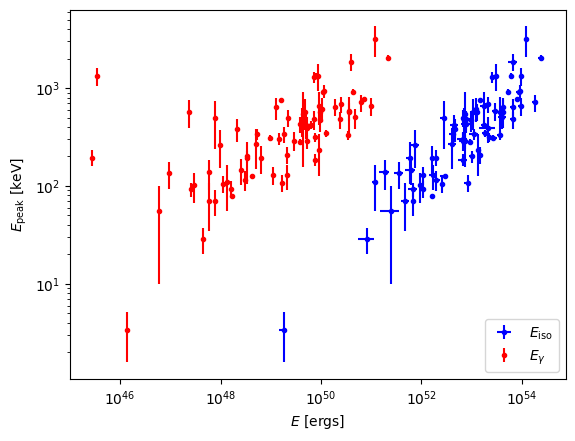

In [2]:
Egamma = Eiso * (1-np.cos(theta))
Egamma_err = np.sqrt((1-np.cos(theta))*(Eiso_err**2) + (Eiso*np.sin(theta))*(theta_err**2))

plt.figure()
plt.errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='.', color='b', label=r'$E_\text{iso}$')
plt.errorbar(Egamma, Epeak, yerr=Epeak_err, fmt='.', color='r', label=r'$E_\gamma$')

plt.loglog()
plt.xlabel(r'$E$ [ergs]')
plt.ylabel(r'$E_\text{peak}$ [keV]')
plt.legend()

Next, similarly to the previous notebook, we'll procede to derive two correlations:
$$
\begin{array}\\
    E_\text{peak} = a \cdot E_\text{iso}^b \\
    E_\text{peak} = c \cdot E_\gamma^d \\
\end{array}
$$
The goal is to compare the parameters values for the best fit of the correlations and compare how correcting for the jet collimation has an effect. As in the above mentioned notebook, we'll use a least squares approach using $\chi^"$ defined as
$$\chi*^2 = \sum_{i=1} ^n \frac{r_i ^2}{\sigma_{r, i} ^2}$$,
where $r_i^2$ is the square of the model-to-computed values and $\sigma_{r, i}^2$ is the total variance of the residuals, also accounting for the errors, i.e. $\sigma_{r, i}^2 = \sigma_{E_\text{peak}}^2 + \left[\sigma_{E_\text{iso}} \left(-abE_\text{iso, i}^b\right)\right]^2$, where the parameters may be subtituted by the homologous for the $E_\gamma$ relation.

In [3]:
def GoF(w,z,x,xerr,y=df['Epeak'],yerr=df['Epeak_err']):
    """
    Returns the chi-squared statistic test accounting for the errors.
    :param w: paramter 1 (normaliation factor)
    :param z: parameter 2 (power-law slope)
    :param x: x-values (Eiso or Egamma)
    :param y: y-values (Epeak)
    :param xerr: errors for x-values
    :param yerr: errors for y-values (Epeak_err)
    :return: chi-squared statistic test
    """

    total_variance = np.zeros(len(xerr))
    total_variance += yerr**2
    total_variance += ((-w*z*x**(z-1))*xerr)**2


    model = w * x**z
    return np.sum(((y-model)**2)/(total_variance))

Now we can go through the different models.

AttributeError: 'Axes' object has no attribute 'colorbar'

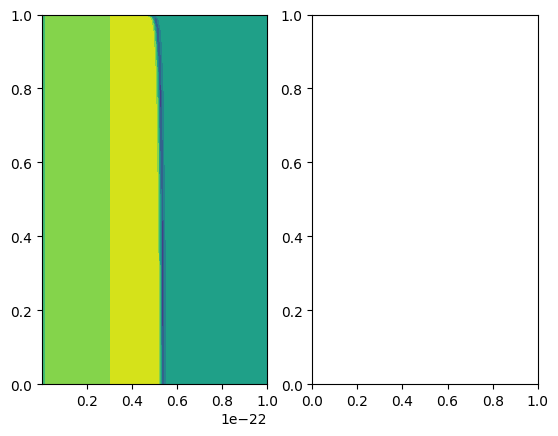

In [4]:
a = np.linspace(10**(-22), 10**(-25), 100)
b = np.linspace(0.0, 1.0,100)
c = np.linspace(10**(-22), 10**(-25), 100)
d = np.linspace(0.0, 1.0, 100)

Giso = np.zeros([len(a), len(b)])
Ggam = np.zeros([len(c), len(d)])

for i in range(len(a)): # since (a,c) and (b,d) have the same length, we can use a single iterator
    for j in range(len(c)):
        Giso[i,j] = GoF(a[i],b[j],x=Eiso,xerr=Eiso_err)
        Ggam[i,j] = GoF(c[i],d[j],x=Egamma,xerr=Egamma_err)

fig, ax = plt.subplots(1,2)
ax[0].contourf(a,b,np.log10(Giso))
ax[0].colorbar()
ax[0].set_xlabel(r'$a$')
ax[0].set_ylabel(r'$b$')
ax[0].set_title(r'$G_\text{iso}$')

ax[1].contourf(c,d,np.log10(Ggam))
ax[1].colorbar()
ax[1].set_xlabel(r'$c$')
ax[1].set_ylabel(r'$d$')
ax[1].set_title(r'$G_\text{gam}$')